In [1]:
import sys
sys.path.append('../src/')
import os
import re
import nibabel as nib
import numpy as np
import scipy
import math

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

from finetune_3D import *
from logistic_regression import *
from models import *
from utils import *

In [3]:
# cbi lr=0.1, sbi lr=0.01
df = load_experiment('/cluster/home/eharve06/extrapolating-classifier-accuracy-to-bigger-datasets/experiments/OASIS-3_max_iters=3000/n=475_random_state=2001.csv')
print(open('/cluster/home/eharve06/extrapolating-classifier-accuracy-to-bigger-datasets/experiments/OASIS-3_max_iters=3000/n=475_random_state=2001.txt').read())
df.tail()

{'seed': 1001, 'wd1': 0.001, 'wd2': 0}



,epoch,train_loss,train_BA,train_auroc,val_loss,val_BA,val_auroc,test_loss,test_BA,test_auroc
2995,2996,0.379429,[0.87751004],[0.94008032],0.551147,[0.75735294],[0.73529412],0.508696,[0.64452214],[0.66083916]
2996,2997,0.379427,[0.87751004],[0.94008032],0.551148,[0.75735294],[0.73529412],0.508697,[0.64452214],[0.66083916]
2997,2998,0.379425,[0.87751004],[0.94008032],0.551149,[0.75735294],[0.73529412],0.508699,[0.64452214],[0.66083916]
2998,2999,0.379423,[0.87751004],[0.94008032],0.551149,[0.75735294],[0.73529412],0.508701,[0.64452214],[0.66083916]
2999,3000,0.379421,[0.87751004],[0.94008032],0.551150,[0.75735294],[0.73529412],0.508702,[0.64452214],[0.66083916]


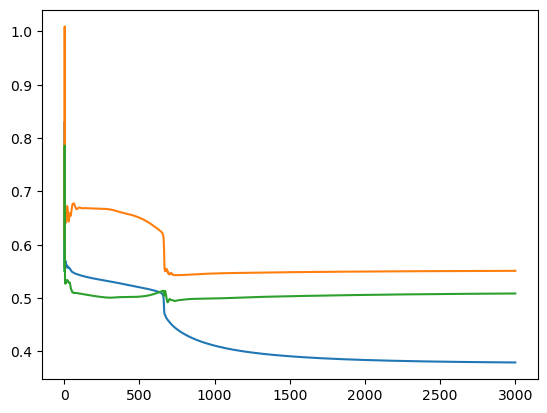

In [4]:
plt.plot(df.epoch.to_list(), df.train_loss.to_list())
plt.plot(df.epoch.to_list(), df.val_loss.to_list())
plt.plot(df.epoch.to_list(), df.test_loss.to_list())

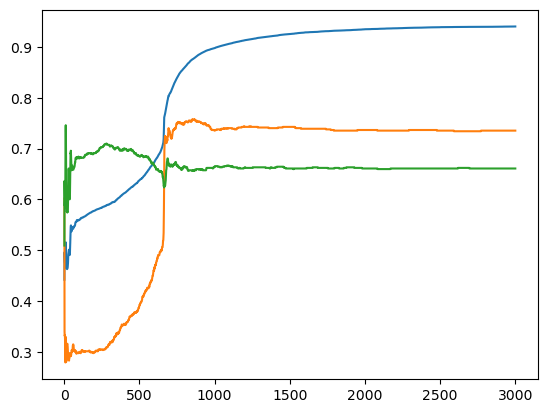

In [5]:
plt.plot(df.epoch.to_list(), np.array(df.train_auroc.to_list())[:,0])
plt.plot(df.epoch.to_list(), np.array(df.val_auroc.to_list())[:,0])
plt.plot(df.epoch.to_list(), np.array(df.test_auroc.to_list())[:,0])

In [6]:
val_performance = np.sum(np.array(df.val_auroc.to_list()), axis=-1)
averaged_performance = np.array([sum(val_performance[index-30:index]) for index in range(30, len(val_performance))])
print(30+np.argmax(averaged_performance))
print(df.test_auroc.to_list()[30+np.argmax(averaged_performance)])

875
[0.65734266]


In [7]:
columns = ['n', 'random_state', 'train_BA', 'train_auroc', 'val_BA', 'val_auroc', 'test_BA', 'test_auroc']
df = pd.DataFrame(columns=columns)

ns = [200, 240, 280, 320, 360, 400, 440, 480, 520, 560, 600]
#ns = [60, 94, 147, 230, 360, 414, 475, 546, 627, 720]
#ns = [60, 94, 147, 230, 475, 546]
random_states = [1001]

for model_index, (n, random_state) in enumerate(itertools.product(ns, random_states)):
    print(open('/cluster/home/eharve06/extrapolating-classifier-accuracy-to-bigger-datasets/experiments/OASIS-3_max_iters=3000/n={}_random_state={}.txt'\
               .format(n, random_state)).read())
    
    temp_df = load_experiment('/cluster/home/eharve06/extrapolating-classifier-accuracy-to-bigger-datasets/experiments/OASIS-3_max_iters=3000/n={}_random_state={}.csv'\
                         .format(n, random_state))
    val_performance = np.sum(np.array(temp_df.val_auroc.to_list()), axis=-1)
    averaged_performance = np.array([sum(val_performance[index-30:index]) for index in range(30, len(val_performance))])
    print(30+np.argmax(averaged_performance))
    train_loss, train_BA, train_auroc, val_loss, val_BA, val_auroc, test_loss, test_BA, test_auroc = temp_df.iloc[30+np.argmax(averaged_performance)].to_list()[1:]
    row = [n, random_state, train_BA, train_auroc, val_BA, val_auroc, test_BA, test_auroc]
    df.loc[model_index] = row

{'wd1': 1e-05, 'wd2': 0.01}

627
{'wd1': 0.0001, 'wd2': 1.0}

2562
{'wd1': 1e-05, 'wd2': 0.1}

1477
{'wd1': 0.01, 'wd2': 1e-05}

1614
{'wd1': 0.001, 'wd2': 0.0}

1024
{'wd1': 0.0, 'wd2': 0.1}

1593
{'wd1': 0.01, 'wd2': 1e-05}

1759
{'wd1': 0.001, 'wd2': 0.01}

1629
{'wd1': 0.001, 'wd2': 1e-05}

2715
{'wd1': 0.01, 'wd2': 0.0}

2282
{'wd1': 0.01, 'wd2': 0.0}

2476


In [8]:
df

,n,random_state,train_BA,train_auroc,val_BA,val_auroc,test_BA,test_auroc
0,200,1001,[0.9969697],[0.99982684],[0.79220779],[0.75678867],[0.57561728],[0.53395062]
1,240,1001,[0.96212121],[0.98857624],[0.80519481],[0.80165289],[0.52777778],[0.50308642]
2,280,1001,[0.94468085],[0.98023641],[0.80519481],[0.80401417],[0.60030864],[0.48868313]
3,320,1001,[0.97120098],[0.99019608],[0.79220779],[0.83943329],[0.53858025],[0.531893]
4,360,1001,[0.97868852],[0.98152012],[0.77922078],[0.78512397],[0.4537037],[0.39506173]
5,400,1001,[0.81715686],[0.89269608],[0.75974026],[0.77567887],[0.55401235],[0.56378601]
6,440,1001,[0.80706522],[0.8584692],[0.76623377],[0.78394333],[0.57407407],[0.59156379]
7,480,1001,[0.97648515],[0.98690724],[0.75974026],[0.77331759],[0.62037037],[0.61213992]
8,520,1001,[0.94889348],[0.95329946],[0.77272727],[0.81345927],[0.66512346],[0.62037037]
9,560,1001,[0.85119048],[0.91581633],[0.78571429],[0.82290437],[0.68209877],[0.64197531]


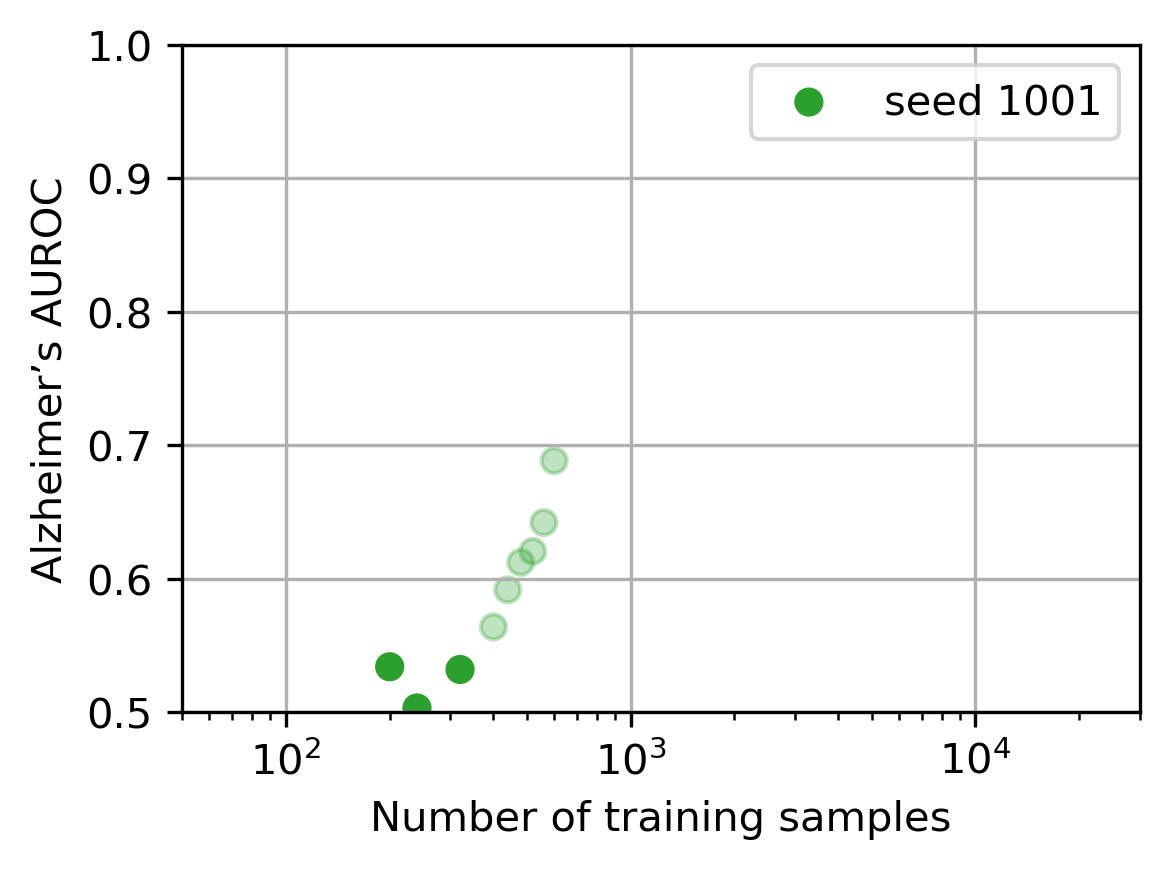

In [9]:
def get_alpha(n):
    if n <= 360:
        return 1.0
    else:
        return 0.3

def plot_experiment(df, labels, random_states=[1001, 2001, 3001]):
    df = df[df.random_state.isin(random_states)]
    colors = ['#2ca02c','#ff7f0e', '#9467bd']
    ncols = len(labels) if len(labels) < 4 else 4
    nrows = math.ceil(len(labels)/4)
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*4, nrows*3), dpi=300)
    for label_index, _ in enumerate(labels):       
        for color, random_state in zip(colors, random_states):
            # Plot data
            temp_df = df[df.random_state==random_state]
            np.array(axs).flatten()[label_index]\
            .scatter(temp_df.n.to_numpy(),
                     np.array(temp_df.test_auroc.to_list())[:,label_index],
                     color = color,
                     alpha=list(map(get_alpha, df.n[df.random_state==random_state].to_list())),
                     label='seed {}'.format(random_state))
        np.array(axs).flatten()[label_index]\
        .set_xlim([50, 30000])
        np.array(axs).flatten()[label_index]\
        .set_ylim([0.5, 1.0])
        np.array(axs).flatten()[label_index]\
        .set_xscale('log')
        np.array(axs).flatten()[label_index]\
        .set_xlabel('Number of training samples')
        np.array(axs).flatten()[label_index]\
        .set_ylabel('{} AUROC'.format(labels[label_index]))
        np.array(axs).flatten()[label_index]\
        .legend()
        np.array(axs).flatten()[label_index]\
        .grid()
    fig.tight_layout()
    plt.show()
    
#df = df.groupby('n').agg(lambda x: list(x))
#df.test_auroc = df.test_auroc.apply(lambda x: np.mean(x, axis=0))
#df.random_state = df.random_state.apply(lambda x: 'mean')
#df = df.reset_index()
#plot_experiment(df, ['Alzheimer’s'], ['mean'])
plot_experiment(df, ['Alzheimer’s'], random_states)